# Convolutional Neural Network from Scratch

In [2]:
import numpy as np
from scipy import signal
from keras.datasets import mnist
from keras.utils import np_utils

2023-10-10 08:02:17.628194: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
# Base Layer

class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input): # returns output
        pass

    def backward(self, output_gradient, learning_rate): # returns input
        pass

## The Dense Layer

#### Forward

$$
y_i = \sum_{k=1}^{i} x_k w_{jk} + b_j
$$

#### Backward

$$
W \gets W - \gamma\frac{\partial E}{\partial Y}X^t \\
B \gets B - \gamma\frac{\partial E}{\partial Y} \\
\frac{\partial E}{\partial X}=W^t\frac{\partial E}{\partial Y}
$$

In [4]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias         # Y = WX + B

    def backward(self, output_gradient, learning_rate):             # returns input
        weights_gradient = np.dot(output_gradient, self.input.T)    # Gradient of the loss w.r.t. weights, computed using the chain rule
        input_gradient = np.dot(self.weights.T, output_gradient)    # Computing and returning the gradient of the loss w.r.t. the input for further backpropagation
        self.weights -= learning_rate * weights_gradient            # Updating the weights using the computed gradient and learning rate
        self.bias -= learning_rate * output_gradient                # Updating the biases using the gradient of the loss w.r.t. biases and learning rate
        return input_gradient                                       # output_gradient is the gradient of the loss w.r.t. the output of this layer

In [5]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

## The Convolutional Layer

#### Forward Computations

$$
Y_i = B_i + \sum_{j=1}^n X_j \star K_{ij}
$$

#### Backward Computations
$$
\frac{\partial E}{\partial K_{ij}} = X_j \star \frac{\partial E}{\partial Y_i} \\
\frac{\partial E}{\partial X_j} = \sum_{i=1}^n \frac{\partial E}{\partial Y_i} \underset{\text{full}}{\star} K_{ij} \\
K \gets K - \gamma \frac{\partial E}{\partial K} \\
B \gets B - \gamma \frac{\partial E}{\partial Y} = B - \gamma \frac{\partial E}{\partial B}
$$

In [6]:
# Convolutional Layer

class Convolutional(Layer):
    def __init__(self, input_shape: tuple, kernel_size: int, depth: int):
        # input_shape shows the depth, height, and width of the input
        # kernel_size represents the size of each matrix inside each kernel
        # depth represents how many kernels we want and also the depth of the output
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
            # depth is the number of kernels
            # input_height - kernel_size + 1 is the height of the output matrix
            # input_width - kernel_size + 1 is the width of the output matrix
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
            # depth is the number of kernels
        self.kernels = np.random.randn(*self.kernels_shape)
            # the * operator unpacks the tuple
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)      # Bi
        for i in range(self.depth):             # Yi
            for j in range(self.input_depth):   # Xj * Kij
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")    # order matters
        return self.output                      # Yi = Bi + SUM Xj * Kij

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)
        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")    # Xj * dE/dYi
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")          # dE/dXj = SUM dE/dYi FULL * Kij

        self.kernels -= learning_rate * kernels_gradient        # Update kernels and
        self.biases -= learning_rate * output_gradient          # biases using gradient descent
        return input_gradient

In [7]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)         # Reshape input to output shape
    
    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)   # Reshape output to input shape

In [8]:
def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [9]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        
        def sigmoid_prime(x):
            return sigmoid(x) * (1 - sigmoid(x))
        
        super().__init__(sigmoid, sigmoid_prime)

In [10]:
def preprocess_binary_data(x, y, limit):
    zero_idx = np.where(y == 0)[0][:limit]
    one_idx = np.where(y == 1)[0][:limit]
    all_idxs = np.hstack((zero_idx, one_idx))
    all_idxs = np.random.permutation(all_idxs)
    x, y = x[all_idxs], y[all_idxs]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_binary_data(x_train, y_train, 100)
x_test, y_test = preprocess_binary_data(x_test, y_test, 100)

In [11]:
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

In [12]:
epochs = 100
learning_rate = 0.1

for epoch in range(epochs):
    error = 0
    for x, y in zip(x_train, y_train):
        output = x
        for layer in network:
            output = layer.forward(output)

        error += binary_cross_entropy(y, output)

        grad = binary_cross_entropy_prime(y, output)
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)

    error /= len(x_train)
    print(f"{epoch + 1}/{epochs}, error = {error}")

1/100, error = 0.3064465619505612
2/100, error = 0.09508077648739185
3/100, error = 0.04380327041703627
4/100, error = 0.028564181635172613
5/100, error = 0.019934598211117607
6/100, error = 0.015327532035199529
7/100, error = 0.010520618477525712
8/100, error = 0.008596969042119016
9/100, error = 0.007196816213966001
10/100, error = 0.006195403452882778
11/100, error = 0.00558478660318953
12/100, error = 0.005162743069800224
13/100, error = 0.0047911285428213395
14/100, error = 0.004439936965924434
15/100, error = 0.004106478323505728
16/100, error = 0.0038103923523334247
17/100, error = 0.003505785053200543
18/100, error = 0.003223389366941668
19/100, error = 0.0029649876421655743
20/100, error = 0.002739950364276919
21/100, error = 0.0025546033402801833
22/100, error = 0.0023983835942183716
23/100, error = 0.0022597088209570172
24/100, error = 0.0021337211942454573
25/100, error = 0.0020188476273399055
26/100, error = 0.0019153144161252506
27/100, error = 0.0018233786728813692
28/10

In [22]:
for x, y in zip(x_test, y_test):
    output = x
    for layer in network:
        output = layer.forward(output)
    print(f"pred => \t{np.argmax(output)}, {np.argmax(y)} <- True")

pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	0, [[1.]
 [0.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1, [[0.]
 [1.]] <- True
pred => 	1

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def importImage(image_location: str):
    with Image.open(image_location) as img:
        image = img.convert('L')
        width, height = image.size
        values = np.zeros((height, width), dtype=np.float32)

        for y in range(height):
            for x in range(width):
                values[y][x] = image.getpixel((x,y))/255

    values = values.reshape(1, height, width)

    print(values.shape)

    return values.astype("float32")

def determineValue(image_array):
    output = image_array
    plt.imshow(output[0])
    plt.axis("off")
    plt.show()
    for layer in network:
        output = layer.forward(output)
    print(f"This is a {np.argmax(output)}")

(1, 28, 28)


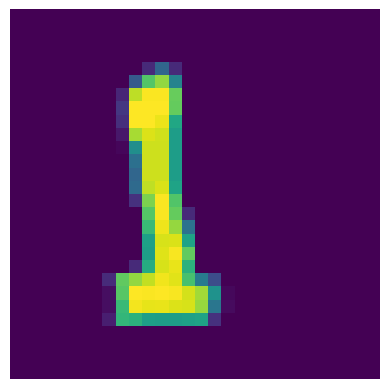

This is a 0


In [15]:
x = importImage(os.path.expanduser('~/Downloads/Untitled.png'))
determineValue(x)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

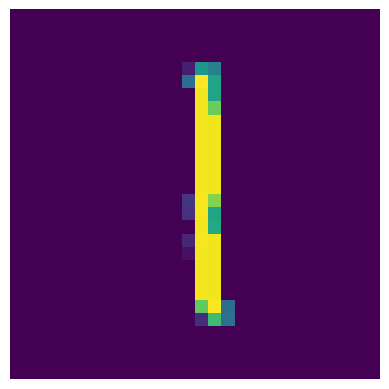

In [20]:
plt.imshow(x_test[92][0])
plt.axis("off")
plt.show
print(x_test[92][0])